In [1]:
# J. Ryu, Electron Microscopy and Spectroscopy Lab., Seoul National University
from scipy import stats
import numpy as np
import hyperspy.api as hys
import matplotlib.pyplot as plt
import matplotlib.patches as pch
import tkinter.filedialog as tkf
from scipy import optimize
import ipywidgets as pyw
import time
import tifffile
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
# refer to "github.com/mkolopanis/python/blob/master/radialProfile.py"
def radial_stats(image, center=None, var=True):
   
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0], x - center[1])
    #plt.imshow(r, cmap="Accent")
    #plt.show()

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = np.around(r_sorted)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    #print(nr)
    
    csim = np.cumsum(i_sorted, dtype=float)
    sq_csim = np.cumsum(np.square(i_sorted), dtype=float)
    radial_avg  = (csim[rind[1:]] - csim[rind[:-1]]) / nr
    
    if var:    
        avg_square = np.square(radial_avg)
        square_avg = (sq_csim[rind[1:]] - sq_csim[rind[:-1]]) / nr
        mask = avg_square.copy()
        mask[np.where(avg_square==0)] = 1.0
        radial_var = (square_avg - avg_square) / mask
        return r, radial_avg, radial_var, (square_avg - avg_square)
    
    else:
        return r, radial_avg
    
def load_binary_4D_stack(img_adr, datatype, original_shape, final_shape, log_scale=False):
    stack = np.fromfile(img_adr, dtype=datatype)
    stack = stack.reshape(original_shape)
    print(stack.shape)
    if log_scale:
        stack = np.log(stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]])
    else:
        stack = stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]]
    
    print(stack.shape) 
    return stack

def fourd_roll_axis(stack):
    stack = np.rollaxis(np.rollaxis(stack, 2, 0), 3, 1)
    return stack

def remove_center_beam(image, center=None, cb_rad=0):
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0], x - center[1])
    r = np.around(r)
    ri = np.where(r<=cb_rad)
    
    image[ri] = 0
    
    return image

def radial_indices(shape, radial_range, center=None):
    y, x = np.indices(shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
    
    r = np.hypot(y - center[0], x - center[1])
    ri = np.ones(r.shape)
    
    if len(np.unique(radial_range)) > 1:
        ri[np.where(r <= radial_range[0])] = 0
        ri[np.where(r > radial_range[1])] = 0
        
    else:
        r = np.round(r)
        ri[np.where(r != round(radial_range[0]))] = 0
    
    return ri

def indices_at_r(shape, radius, center=None):
    y, x = np.indices(shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
    r = np.hypot(y - center[0], x - center[1])
    r = np.around(r)
    
    ri = np.where(r == radius)
    
    angle_arr = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            angle_arr[i, j] = np.angle(complex(x[i, j]-center[1], y[i, j]-center[0]), deg=True)
            
    angle_arr = angle_arr + 180
    angle_arr = np.around(angle_arr)
    
    ai = np.argsort(angle_arr[ri])
    r_sort = (ri[1][ai], ri[0][ai])
    a_sort = np.sort(angle_arr[ri])
        
    return r_sort, a_sort

def local_var_similarity(var_map, w_size, stride):
    var_map = np.asarray(var_map)
    rows = range(0, var_map.shape[0]-w_size+1, stride)
    cols = range(0, var_map.shape[1]-w_size+1, stride)
    new_shape = (len(rows), len(cols))
    
    surr_avg = []
    surr_std = []
    surr_dif = []
    for i in rows:
        for j in cols:
            local_region = var_map[i:i+w_size, j:j+w_size].flatten()
            
            if np.max(local_region) != 0.0:
                local_region = local_region / np.max(local_region)
            else:
                local_region = local_region * 0.0
            
            temp_avg = np.mean(local_region)
            temp_std = np.std(local_region)
            surr_avg.append(temp_avg)
            surr_std.append(temp_std)
            diff_mse = np.sum(np.square(local_region - local_region[int(w_size**2/2)]))/(w_size**2-1)
            surr_dif.append(diff_mse)
            
    surr_avg = np.asarray(surr_avg).reshape(new_shape)
    surr_std = np.asarray(surr_std).reshape(new_shape)
    surr_dif = np.asarray(surr_dif).reshape(new_shape)
    
    return surr_avg, surr_std, surr_dif, new_shape

def local_DP_similarity(f_flat, w_size, stride):
    f_flat = np.asarray(f_flat)
    rows = range(0, f_flat.shape[0]-w_size+1, stride)
    cols = range(0, f_flat.shape[1]-w_size+1, stride)
    new_shape = (len(rows), len(cols))
    
    dp_mse = []
    dp_ssim = []
    for i in rows:
        for j in cols:        
            local_region = f_flat[i:i+w_size, j:j+w_size].reshape(w_size**2, -1)
            ref_dp = local_region[int(w_size**2/2)]
            local_region = np.delete(local_region, int(w_size**2/2), axis=0)
            tmp_mse = []
            tmp_ssim = []
            for fdp in local_region:
                tmp_mse.append(mean_squared_error(ref_dp/np.max(ref_dp), fdp/np.max(fdp)))
                tmp_ssim.append(ssim(ref_dp/np.max(ref_dp), fdp/np.max(fdp)))
                
            dp_mse.append(np.mean(tmp_mse))
            dp_ssim.append(np.mean(tmp_ssim))
            
    dp_mse = np.asarray(dp_mse).reshape(new_shape)
    dp_ssim = np.asarray(dp_ssim).reshape(new_shape)
    
    return dp_mse, dp_ssim, new_shape

# load data

In [62]:
raw_adr = tkf.askopenfilename()
print(raw_adr)

E:/data_temporary/20220323_amorphous_carbon_TZ/4D-STEM/B40/cropped_04_2_B40.dm4


In [63]:
# Load a data (DM)
stack_4d = hys.load(raw_adr).data
stack_4d = fourd_roll_axis(stack_4d)
#stack_4d = tifffile.imread(raw_adr)
print(stack_4d.shape)
f_shape = stack_4d.shape

stack_4d = stack_4d / np.max(stack_4d)
if np.isnan(np.max(stack_4d)):
    print("NaN exists")
    stack_4d = np.nan_to_num(stack_4d)
stack_4d = stack_4d.clip(min=0.0)
print(np.max(stack_4d))
print(np.min(stack_4d))
print(np.mean(stack_4d))

stack_4d_original = stack_4d.copy()

(55, 128, 128, 128)
1.0
3.0328074e-06
0.0034949544


# intensity map

In [ ]:
%matplotlib widget

In [ ]:
%matplotlib inline

(55, 128)
1.0
0.7623327
0.84179324
0.8384011


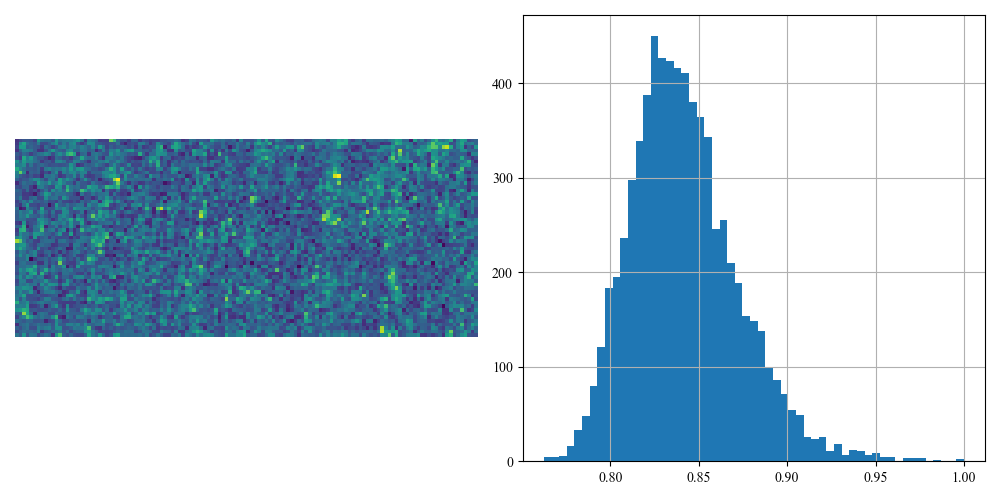

In [64]:
# maximum intensity distribution
max_int = np.max(stack_4d, axis=(2, 3))
print(max_int.shape)
print(np.max(max_int))
print(np.min(max_int))
print(np.mean(max_int))
print(np.median(max_int))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(max_int, cmap="viridis")
ax[0].axis("off")
ax[1].hist(max_int.flatten(), bins=len(max_int))
ax[1].grid()
fig.tight_layout()
plt.show()

(55, 128)
58.72712
55.964653
57.26115
57.229935


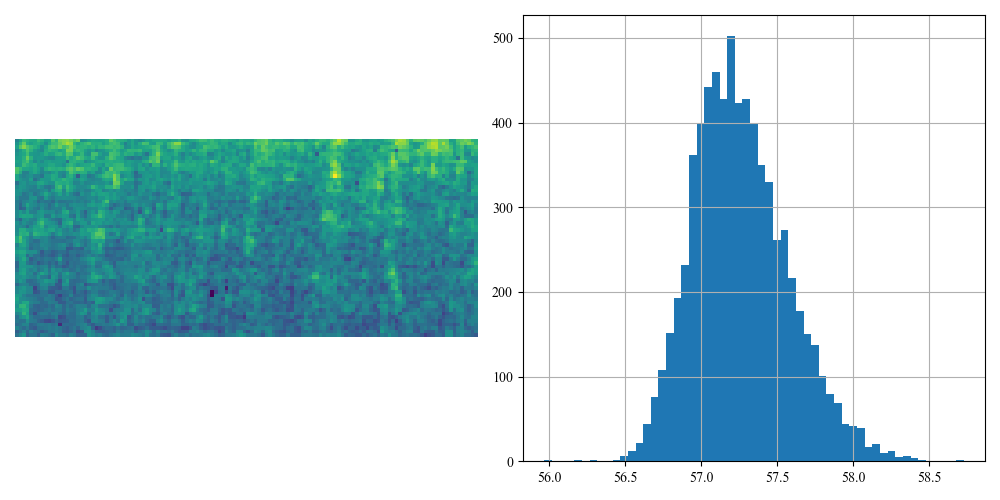

In [65]:
# total intensity distribution
tot_int = np.sum(stack_4d, axis=(2, 3))
print(max_int.shape)
print(np.max(tot_int))
print(np.min(tot_int))
print(np.mean(tot_int))
print(np.median(tot_int))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(tot_int, cmap="viridis")
ax[0].axis("off")
ax[1].hist(tot_int.flatten(), bins=len(max_int))
ax[1].grid()
fig.tight_layout()
plt.show()

# center position

[63.33896445578041, 64.29986608974762]


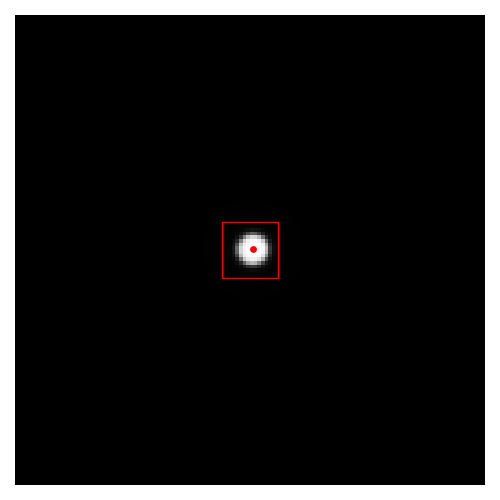

In [66]:
# find the center position (center of mass)
mean_dp = np.mean(stack_4d, axis=(0, 1))
cbox_edge = 15
cbox_outy = int(mean_dp.shape[0]/2 - cbox_edge/2)
cbox_outx = int(mean_dp.shape[1]/2 - cbox_edge/2)
center_box = mean_dp[cbox_outy:-cbox_outy, cbox_outx:-cbox_outx]
Y, X = np.indices(center_box.shape)
com_y = np.sum(center_box * Y) / np.sum(center_box)
com_x = np.sum(center_box * X) / np.sum(center_box)
c_pos_original = [com_y+cbox_outy, com_x+cbox_outx]
c_pos = [com_y+cbox_outy, com_x+cbox_outx]
print(c_pos)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(mean_dp, cmap="gray")
ax.axis("off")
ax.scatter(c_pos[1], c_pos[0], s=15, c="r")
ax.add_patch(pch.Rectangle((cbox_outx, cbox_outy), cbox_edge, cbox_edge, 
                           linewidth=1, edgecolor="r", facecolor="none"))
fig.tight_layout()
plt.show()

In [67]:
radial_map, mean_dp_radial_avg = radial_stats(mean_dp, center=c_pos, var=False)

# obtain variance map dpending on k-vector
square_avg = np.mean(np.square(stack_4d), axis=(0,1))
avg_square = np.square(np.mean(stack_4d, axis=(0,1)))
mask = avg_square.copy()
mask[np.where(avg_square == 0)] = 1.0
var_map = (square_avg - avg_square) / mask

# obtain radial average prifile for variance map above
radial_map, kp_var = radial_stats(var_map, center=c_pos, var=False)
print(kp_var.shape)
print(np.argmax(kp_var))

(89,)
76


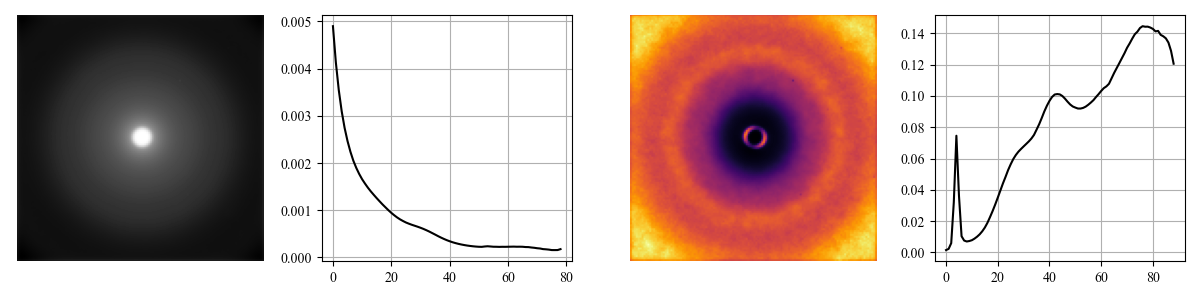

In [68]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].imshow(np.log(mean_dp), cmap="gray")
ax[0].axis("off")
ax[1].plot(mean_dp_radial_avg[10:], "k-")
ax[1].grid()
ax[2].imshow(var_map, cmap="inferno")
ax[2].axis("off")
ax[3].plot(kp_var, "k-")
ax[3].grid()
fig.tight_layout()
plt.show()

In [ ]:
side_length = 40
box_size = np.array([side_length, side_length])
dataset = []

h_si = np.floor(c_pos[0]-box_size[0]).astype(int)
h_fi = np.ceil(c_pos[0]+box_size[0]).astype(int)
w_si = np.floor(c_pos[1]-box_size[1]).astype(int)
w_fi = np.ceil(c_pos[1]+box_size[1]).astype(int)

stack_4d = stack_4d[:, :, h_si:h_fi, w_si:w_fi]
f_shape = stack_4d.shape
print(f_shape)

In [ ]:
# find the center position (center of mass)
mean_dp = np.mean(stack_4d, axis=(0, 1))
cbox_edge = 30
cbox_outy = int(mean_dp.shape[0]/2 - cbox_edge/2)
cbox_outx = int(mean_dp.shape[1]/2 - cbox_edge/2)
center_box = mean_dp[cbox_outy:-cbox_outy, cbox_outx:-cbox_outx]
Y, X = np.indices(center_box.shape)
com_y = np.sum(center_box * Y) / np.sum(center_box)
com_x = np.sum(center_box * X) / np.sum(center_box)
c_pos = [com_y+cbox_outy, com_x+cbox_outx]
print(c_pos)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(mean_dp, cmap="gray")
ax.axis("off")
ax.scatter(c_pos[1], c_pos[0], s=15, c="r")
ax.add_patch(pch.Rectangle((cbox_outx, cbox_outy), cbox_edge, cbox_edge, 
                           linewidth=1, edgecolor="r", facecolor="none"))
fig.tight_layout()
plt.show()

In [ ]:
radial_map, mean_dp_radial_avg = radial_stats(mean_dp, center=c_pos, var=False)

# obtain variance map dpending on k-vector
square_avg = np.mean(np.square(stack_4d), axis=(0,1))
avg_square = np.square(np.mean(stack_4d, axis=(0,1)))
mask = avg_square.copy()
mask[np.where(avg_square == 0)] = 1.0
var_map = (square_avg - avg_square) / mask

# obtain radial average prifile for variance map above
radial_map, kp_var = radial_stats(var_map, center=c_pos, var=False)
print(kp_var.shape)
print(np.argmax(kp_var))

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].imshow(np.log(mean_dp), cmap="gray")
ax[0].axis("off")
ax[1].plot(mean_dp_radial_avg, "k-")
ax[1].grid()
ax[2].imshow(var_map, cmap="inferno")
ax[2].axis("off")
ax[3].plot(kp_var, "k-")
ax[3].grid()
fig.tight_layout()
plt.show()

# rotational average

In [69]:
%matplotlib inline

In [13]:
%matplotlib widget

In [70]:
# radial average of DPs (not variance, intensity direcltly, RDF?)
radial_avg_stack = []
len_profile = []
for i in range(f_shape[0]):
    for j in range(f_shape[1]):
        _, radial_temp = radial_stats(stack_4d[i, j], center=c_pos, var=False)
        len_profile.append(len(radial_temp))
        radial_avg_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(radial_avg_stack)):
        radial_avg_stack[i] = radial_avg_stack[i][:shortest]

radial_avg_stack = np.asarray(radial_avg_stack).reshape(f_shape[0], f_shape[1], -1)
print(radial_avg_stack.shape)

radial_avg_sum = np.sum(radial_avg_stack, axis=(0, 1))
print(radial_avg_sum.shape)

(55, 128, 89)
(89,)


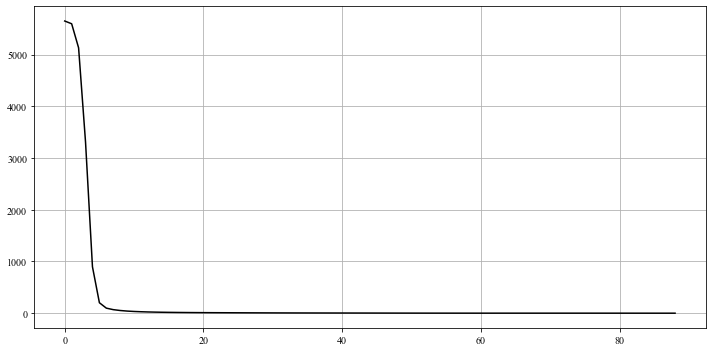

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(radial_avg_sum, "k-")
ax.grid()
fig.tight_layout()
plt.show()

In [ ]:
# save (radial average, 3D)
tifffile.imsave(raw_adr[:-4]+"_radial_avg_radial.tif", radial_avg_stack)

# k-radial FEM

In [ ]:
%matplotlib inline

In [51]:
%matplotlib widget

In [72]:
# calculate variance with all angles at a certain k
radial_var_stack = []
len_profile = []
for i in range(f_shape[0]):
    for j in range(f_shape[1]):
        _, _, radial_temp, _ = radial_stats(stack_4d[i, j], center=c_pos, var=True)
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(f_shape[0], f_shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

(55, 128, 89)
(89,)


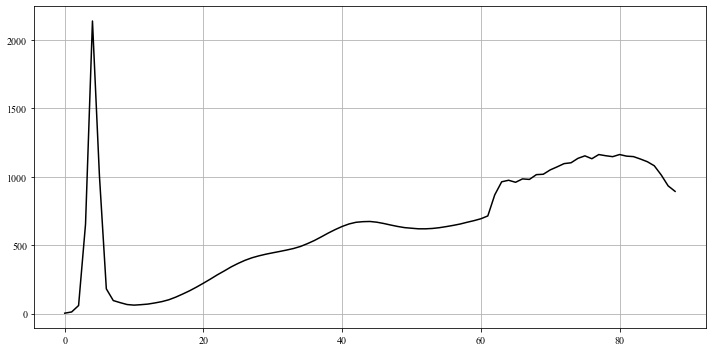

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(radial_var_sum, "k-")
ax.grid()
fig.tight_layout()
plt.show()

In [74]:
radial_var = radial_var_stack.copy()
radial_var_spectrum = radial_var_sum.copy()

In [ ]:
# save (radial variance, 3D)
tifffile.imsave(raw_adr[:-4]+"_radial_var_radial.tif", radial_var_stack)

# local similarity

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib widget

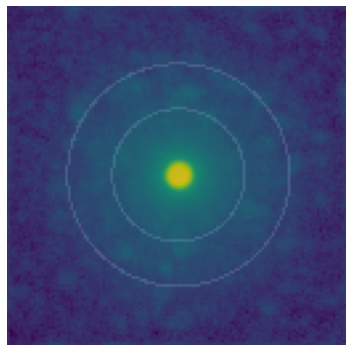

In [75]:
tmp_radius = [25, 42]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(np.log(stack_4d[10, 10]))
ax.axis("off")
for r in tmp_radius:
    tmp = radial_indices(f_shape[2:], [r], center=c_pos)
    ax.imshow(tmp, alpha=0.1, cmap="gray")
fig.tight_layout()
plt.show()

In [ ]:
plt.close('all')

In [76]:
win_size = 3
stride = 1
k_selected = 25

In [77]:
k_var_map = radial_var[:, :, k_selected].copy()
#k_var_map = k_var_map.clip(max=np.percentile(k_var_map, 99))

local_avg, local_std, local_dif, bin_shape = local_var_similarity(k_var_map, win_size, stride)
print(local_avg.shape)
print(local_std.shape)
print(local_dif.shape)

mask = np.zeros(k_var_map.shape)
mask[int((win_size-1)/2):-int(win_size/2), int((win_size-1)/2):-int(win_size/2)] = 1

print(mask[int((win_size-1)/2):-int(win_size/2), int((win_size-1)/2):-int(win_size/2)].shape)
print(bin_shape)

(53, 126)
(53, 126)
(53, 126)
(53, 126)
(53, 126)


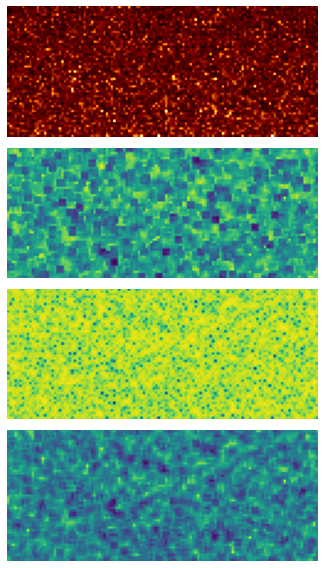

In [78]:
fig, ax = plt.subplots(4, 1, figsize=(5, 8))
ax[0].imshow(k_var_map[int((win_size-1)/2):-int(win_size/2), int((win_size-1)/2):-int(win_size/2)], cmap="afmhot")
#ax[0].imshow(mask, cmap="gray", alpha=0.5)
ax[0].axis("off")
ax[1].imshow(local_avg, cmap="viridis")
ax[1].axis("off")
ax[2].imshow(-local_dif, cmap="viridis")
ax[2].axis("off")
ax[3].imshow(-local_std, cmap="viridis")
ax[3].axis("off")
fig.tight_layout()
plt.show()

In [79]:
k_ind, a_ind = indices_at_r(f_shape[2:], k_selected, c_pos)

f_flat = stack_4d[:, :, k_ind[0], k_ind[1]]
print(f_flat.shape)

dp_mse, dp_ssim, bin_shape = local_DP_similarity(f_flat, win_size, stride)
print(dp_mse.shape)
print(dp_ssim.shape)

mask = np.zeros(f_flat.shape[:2])
mask[int((win_size-1)/2):-int(win_size/2), int((win_size-1)/2):-int(win_size/2)] = 1

(55, 128, 158)
(53, 126)
(53, 126)


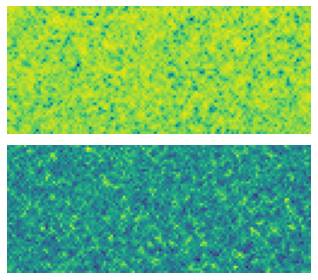

In [80]:
fig, ax = plt.subplots(2, 1, figsize=(5, 4))
ax[0].imshow(-dp_mse, cmap="viridis")
ax[0].axis("off")
ax[1].imshow(dp_ssim, cmap="viridis")
ax[1].axis("off")
fig.tight_layout()
plt.show()

(53, 126)
(53, 126)
(53, 126)
(53, 126)
(53, 126)


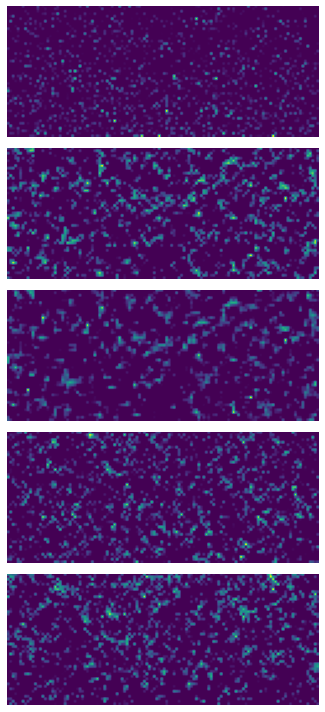

In [81]:
th_sigma = [0.6, 0.6, 0.6, 0.6, 0.6]
high_var = k_var_map.clip(min=(np.mean(k_var_map)+th_sigma[0]*np.std(k_var_map)))[int((win_size-1)/2):-int(win_size/2), int((win_size-1)/2):-int(win_size/2)]
print(high_var.shape)
low_dif = local_dif.clip(max=(np.mean(local_dif)-th_sigma[1]*np.std(local_dif)))
print(low_dif.shape)
low_std = local_std.clip(max=(np.mean(local_std)-th_sigma[2]*np.std(local_std)))
print(low_std.shape)
high_ssim = dp_ssim.clip(min=(np.mean(dp_ssim)+th_sigma[3]*np.std(dp_ssim)))
print(high_ssim.shape)
low_mse = dp_mse.clip(max=(np.mean(dp_mse)-th_sigma[4]*np.std(dp_mse)))
print(low_mse.shape)

fig, ax = plt.subplots(5, 1, figsize=(5, 10))
ax[0].imshow(high_var, cmap="viridis")
ax[0].axis("off")
ax[1].imshow(-low_dif, cmap="viridis")
ax[1].axis("off")
ax[2].imshow(-low_std, cmap="viridis")
ax[2].axis("off")
ax[3].imshow(high_ssim, cmap="viridis")
ax[3].axis("off")
ax[4].imshow(-low_mse, cmap="viridis")
ax[4].axis("off")
fig.tight_layout()
plt.show()

In [ ]:
plt.close("all")

In [31]:
def local_similarity(var_map, f_flat, w_size, rows, cols):
    new_shape = (len(rows), len(cols))
    
    surr_avg = []
    surr_std = []
    surr_dif = []
    for i in rows:
        for j in cols:
            local_region = var_map[i:i+w_size, j:j+w_size].flatten()
            
            if np.max(local_region) != 0.0:
                local_region = local_region / np.max(local_region)
            else:
                local_region = local_region * 0.0
            
            temp_avg = np.mean(local_region)
            temp_std = np.std(local_region)
            surr_avg.append(temp_avg)
            surr_std.append(temp_std)
            diff_mse = np.sum(np.square(local_region - local_region[int(w_size**2/2)]))/(w_size**2-1)
            surr_dif.append(diff_mse)
            
    surr_avg = np.asarray(surr_avg).reshape(new_shape)
    surr_std = np.asarray(surr_std).reshape(new_shape)
    surr_dif = np.asarray(surr_dif).reshape(new_shape)
    
    dp_mse = []
    dp_ssim = []
    for i in rows:
        for j in cols:        
            local_region = f_flat[i:i+w_size, j:j+w_size].reshape(w_size**2, -1)
            ref_dp = local_region[int(w_size**2/2)]
            local_region = np.delete(local_region, int(w_size**2/2), axis=0)
            tmp_mse = []
            tmp_ssim = []
            for fdp in local_region:
                tmp_mse.append(mean_squared_error(ref_dp/np.max(ref_dp), fdp/np.max(fdp)))
                tmp_ssim.append(ssim(ref_dp/np.max(ref_dp), fdp/np.max(fdp)))
                
            dp_mse.append(np.mean(tmp_mse))
            dp_ssim.append(np.mean(tmp_ssim))
            
    dp_mse = np.asarray(dp_mse).reshape(new_shape)
    dp_ssim = np.asarray(dp_ssim).reshape(new_shape)
    
    
    return surr_avg, surr_std, surr_dif, dp_mse, dp_ssim, new_shape

In [32]:
k_selected = 25
k_var_map = radial_var[:, :, k_selected].copy()
k_ind, a_ind = indices_at_r(f_shape[2:], k_selected, c_pos)
f_flat = stack_4d[:, :, k_ind[0], k_ind[1]]

win_sizes = np.array([3, 5, 7, 9, 11])
stride = 1
rows = range(0, f_shape[0]-np.max(win_sizes)+1, stride)
cols = range(0, f_shape[1]-np.max(win_sizes)+1, stride)

In [33]:
var_dif_stack = []
var_std_stack = []
dp_ssim_stack = []
dp_mse_stack = []
for i in range(len(win_sizes)):
    local_avg, local_std, local_dif, dp_mse, dp_ssim, bin_shape = local_similarity(k_var_map, f_flat, win_sizes[i], rows, cols)
    
    var_dif_stack.append(-local_dif)
    var_std_stack.append(-local_std)
    dp_ssim_stack.append(dp_ssim)
    dp_mse_stack.append(-dp_mse)
    
var_dif_stack = np.asarray(var_dif_stack)
print(var_dif_stack.shape)
var_std_stack = np.asarray(var_std_stack)
print(var_std_stack.shape)
dp_ssim_stack = np.asarray(dp_ssim_stack)
print(dp_ssim_stack.shape)
dp_mse_stack = np.asarray(dp_mse_stack)
print(dp_mse_stack.shape)

(5, 45, 118)
(5, 45, 118)
(5, 45, 118)
(5, 45, 118)


In [34]:
var_dif_stack = np.rollaxis(np.rollaxis(var_dif_stack, 2, 0), 2, 0)
print(var_dif_stack.shape)
var_std_stack = np.rollaxis(np.rollaxis(var_std_stack, 2, 0), 2, 0)
print(var_std_stack.shape)
dp_ssim_stack = np.rollaxis(np.rollaxis(dp_ssim_stack, 2, 0), 2, 0)
print(dp_ssim_stack.shape)
dp_mse_stack = np.rollaxis(np.rollaxis(dp_mse_stack, 2, 0), 2, 0)
print(dp_mse_stack.shape)

(45, 118, 5)
(45, 118, 5)
(45, 118, 5)
(45, 118, 5)


In [35]:
%matplotlib inline

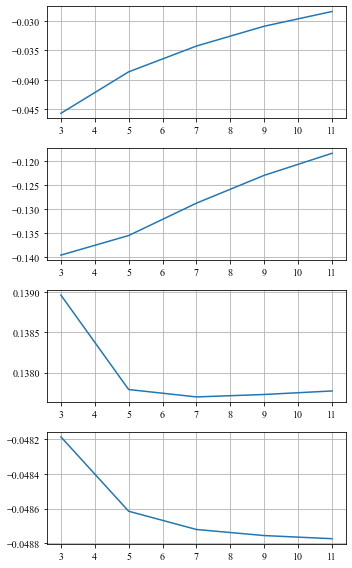

In [36]:
fig, ax = plt.subplots(4, 1, figsize=(5, 8))
ax[0].plot(win_sizes, np.mean(var_dif_stack, axis=(0, 1)))
ax[0].grid()
ax[1].plot(win_sizes, np.mean(var_std_stack, axis=(0, 1)))
ax[1].grid()
ax[2].plot(win_sizes, np.mean(dp_ssim_stack, axis=(0, 1)))
ax[2].grid()
ax[3].plot(win_sizes, np.mean(dp_mse_stack, axis=(0, 1)))
ax[3].grid()
fig.tight_layout()
plt.show()

In [ ]:
local_size = win_size
row_, col_ = 5-int(local_size/2), 5-int(local_size/2)

selected_region = f_flat[row_:row_+local_size, col_:col_+local_size]
print(selected_region.shape)
selected_region = selected_region.reshape(local_size**2, -1)

fig, ax = plt.subplots(local_size, local_size, figsize=(20, 20))
for i, axs in enumerate(ax.flat):
    axs.plot(selected_region[i])
    axs.grid()
    
plt.show()

In [ ]:
th_sigma = 2.9
high_ssim = dp_ssim.clip(min=(np.mean(dp_ssim)+th_sigma*np.std(dp_ssim)))
high_ind = np.where(high_ssim > (np.mean(dp_ssim)+th_sigma*np.std(dp_ssim)))

print(len(high_ind[0]))

In [ ]:
for i in range(len(high_ind[0])):
    y_pos, x_pos = high_ind[0][i], high_ind[1][i]
    print(y_pos, x_pos)

    ref_dp = f_flat[y_pos, x_pos]
    ssim_result = []
    mse_result = []

    for i in range(f_shape[0]):
        for j in range(f_shape[1]):
            tmp_dp = f_flat[i, j]
            mse_result.append(mean_squared_error(ref_dp/np.max(ref_dp), tmp_dp/np.max(tmp_dp)))
            ssim_result.append(ssim(ref_dp/np.max(ref_dp), tmp_dp/np.max(tmp_dp)))

    ssim_result = np.asarray(ssim_result).reshape(f_shape[:2])
    ssim_result = ssim_result / np.max(ssim_result)
    mse_result = np.asarray(mse_result).reshape(f_shape[:2])
    mse_result = mse_result / np.max(mse_result)

    ssim_result[y_pos, x_pos] = 0.0
    mse_result[y_pos, x_pos] = 1.0

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(-mse_result, cmap="viridis")
    ax[0].scatter(x_pos, y_pos, c="red")
    ax[0].axis("off")
    ax[1].imshow(ssim_result, cmap="viridis")
    ax[1].scatter(x_pos, y_pos, c="red")
    ax[1].axis("off")
    fig.tight_layout()
    plt.show()

# angular correlation

In [ ]:
k_range = np.arange(20, 40, 5)
start_time = time.process_time()
ac_spectra = []
ac_fft_stack = []
angle_sampling = 361
angles = np.arange(angle_sampling)
tril_mask = np.ones((angle_sampling, angle_sampling))
tril_mask = np.triu(tril_mask, 0)
tril_mask[np.where(tril_mask==0)] = np.nan

for k in k_range:
    k_ind, a_ind = indices_at_r(f_shape[2:], k, c_pos)
    temp_spectra = []
    temp_fft_stack = []
    for i in range(f_shape[0]):
        for j in range(f_shape[1]):
            value_sel = stack_4d[i, j, k_ind[0], k_ind[1]]
            values = np.zeros(angle_sampling)
            values[a_ind.astype(int)] = value_sel

            dummy = np.roll(values, 1)
            value_stack = np.vstack((values, dummy))
            for l in range(len(values)-2):
                dummy = np.roll(dummy, 1)
                value_stack = np.vstack((value_stack, dummy))

            ang_corr = np.multiply(value_stack, values[np.newaxis, :])
            ang_corr = np.multiply(np.triu(ang_corr, 0), tril_mask)

            value_avgsq = np.mean(value_sel)**2
            ac_spectrum = np.nanmean(ang_corr, axis=1)
            ac_spectrum = (ac_spectrum / value_avgsq) - 1
            ac_fft = np.abs(np.fft.fft(ac_spectrum))
            
            temp_spectra.append(ac_spectrum)
            temp_fft_stack.append(ac_fft)
            
    temp_spectra = np.asarray(temp_spectra).reshape(f_shape[0], f_shape[1], -1)
    temp_fft_stack = np.asarray(temp_fft_stack).reshape(f_shape[0], f_shape[1], -1)
    ac_spectra.append(temp_spectra)
    ac_fft_stack.append(temp_fft_stack)
    print("%d radius completed"%(k))
    print("%d seconds have passed"%(time.process_time()-start_time))
print("all done")

In [ ]:
ac_spectra = np.asarray(ac_spectra)
print(ac_spectra.shape)
ac_fft_stack = np.asarray(ac_fft_stack)
print(ac_fft_stack.shape)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(np.flip(np.mean(ac_spectra, axis=(1, 2)).T, 0), cmap="viridis", 
             extent=[k_range[0], k_range[-1], angles[0]/10, angles[-1]/10])
ax[1].imshow(np.flip(np.mean(ac_fft_stack, axis=(1, 2)).T[1:11], 0), cmap="viridis", 
             extent=[k_range[0], k_range[-1], 0.5, 10.5])
fig.tight_layout()
plt.show()

In [ ]:
k_ind = np.where(k_range==25)[0][0]
print(k_ind)
rot_sym = [2, 3, 4, 5, 6, 10]

ang_corr_rot = []
for r in rot_sym:
    ang_corr_rot.append(ac_fft_stack[k_ind, :, :, r]/np.max(ac_fft_stack[k_ind, :, :, r]))
ang_corr_rot = np.asarray(ang_corr_rot)
print(ang_corr_rot.shape)

k_var_map = radial_var[:, :, k_selected]
for i, r in enumerate(rot_sym):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(ang_corr_rot[i], cmap="afmhot")
    ax[0].axis("off")
    ax[0].set_title("rotation symmetry %d"%r)
    ax[1].imshow(k_var_map, cmap="afmhot")
    ax[1].axis("off")
    ax[2].imshow(ang_corr_rot[i], cmap="afmhot", alpha=0.8)
    ax[2].contour(k_var_map, colors="k", alpha=1.0, levels=5)
    ax[2].axis("off")
    fig.tight_layout()
    plt.show()